In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
#from sklearn.pipeline import make_pipeline
import numpy as np
# import jieba


# 1. 初步分析

### 加载数据

In [19]:
pd_all = pd.read_csv('online_shopping_10_cats.csv')

print('评论数目（总体）：%d' % pd_all.shape[0])
print('评论数目（正向）：%d' % pd_all[pd_all.label==1].shape[0])
print('评论数目（负向）：%d' % pd_all[pd_all.label==0].shape[0])

评论数目（总体）：62774
评论数目（正向）：31728
评论数目（负向）：31046


### 字段说明

| 字段 | 说明 |
| ---- | ---- |
| cat | 类别：包括 书籍、平板、手机、水果、洗发水、热水器、蒙牛、衣服、计算机、酒店 |
| label | 1 表示正向评论，0 表示负向评论 |
| review | 评论内容 |

In [20]:
pd_all.sample(20)

,cat,label,review
57586,酒店,1,"在上海光大这个地区,如家的价格还是非常好的!它的对门以前是一个老的国营旅馆(名称叫酒店,其实..."
32511,洗发水,0,我以为改版了呢 跟原来没啥区别 还好意思说自己无硅油… 无语
8691,平板,1,对我们老年人来讲，还可以 非常满意，看看电视剧方便。
2256,书籍,0,这本书看得我实在是没什么感觉。作者说的很抽象，我感觉挺空洞的，没什么意思。有点后悔买这本书。
18531,水果,1,苹果还算不错！！不过其中一箱比另外一箱小，还有个别心烂的果
49288,计算机,1,"价格便宜!体积小!重量轻!质量一般,不过一分钱一分货嘛!配置还成！"
38806,衣服,1,有点大了！但是还凑合！不错！值得拥有
32276,洗发水,0,差评没商量，买完就**降价
22507,水果,0,这个苹果是我买过最差的了，没有苹果的味道，口感不好，不会再买了
47139,衣服,0,不值这个价，实体店这么多钱买的质量都要好！


## 2. 统计各类别语料的规模

In [21]:
all_cats = ['书籍', '平板', '手机', '水果', '洗发水', '热水器', '蒙牛', '衣服', '计算机', '酒店'] # 全部类别

for cat in all_cats:
    pd_data = pd_all[pd_all.cat==cat]
    print('{}: {} (总体), {} (正例), {} (负例)'.format(cat, pd_data.shape[0], 
                                                 pd_data[pd_data.label==1].shape[0], pd_data[pd_data.label==0].shape[0]))

书籍: 3851 (总体), 2100 (正例), 1751 (负例)
平板: 10000 (总体), 5000 (正例), 5000 (负例)
手机: 2323 (总体), 1165 (正例), 1158 (负例)
水果: 10000 (总体), 5000 (正例), 5000 (负例)
洗发水: 10000 (总体), 5000 (正例), 5000 (负例)
热水器: 575 (总体), 475 (正例), 100 (负例)
蒙牛: 2033 (总体), 992 (正例), 1041 (负例)
衣服: 10000 (总体), 5000 (正例), 5000 (负例)
计算机: 3992 (总体), 1996 (正例), 1996 (负例)
酒店: 10000 (总体), 5000 (正例), 5000 (负例)


In [22]:
import matplotlib.pyplot as plt
import pandas as pd

# 设置英文字体 
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 12

# 生成统计数据集
category_stats = []
for cat in pd_all['cat'].unique():
    subset = pd_all[pd_all['cat'] == cat]
    total = subset.shape[0]
    pos = subset[subset.label == 1].shape[0]
    neg = subset[subset.label == 0].shape[0]
    category_stats.append({
        'Category': cat,
        'Total': total,
        'Positive': pos,
        'Negative': neg,
        'Pos_Ratio': pos/total,
        'Neg_Ratio': neg/total
    })

stats_df = pd.DataFrame(category_stats).sort_values('Total', ascending=False)

# 生成统计表格
stats_table = stats_df[['Category', 'Total', 'Positive', 'Negative', 'Pos_Ratio', 'Neg_Ratio']]
stats_table['Pos_Ratio'] = stats_table['Pos_Ratio'].apply(lambda x: f"{x:.1%}")
stats_table['Neg_Ratio'] = stats_table['Neg_Ratio'].apply(lambda x: f"{x:.1%}")

print("Category Statistics:")
display(stats_table.style.format({
    'Total': '{:,}',
    'Positive': '{:,}',
    'Negative': '{:,}'
}))


Category Statistics:


,Category,Total,Positive,Negative,Pos_Ratio,Neg_Ratio
1,平板,"10,000","5,000","5,000",50.0%,50.0%
3,水果,"10,000","5,000","5,000",50.0%,50.0%
4,洗发水,"10,000","5,000","5,000",50.0%,50.0%
7,衣服,"10,000","5,000","5,000",50.0%,50.0%
9,酒店,"10,000","5,000","5,000",50.0%,50.0%
8,计算机,"3,992","1,996","1,996",50.0%,50.0%
0,书籍,"3,851","2,100","1,751",54.5%,45.5%
2,手机,"2,323","1,165","1,158",50.2%,49.8%
6,蒙牛,"2,033",992,"1,041",48.8%,51.2%
5,热水器,575,475,100,82.6%,17.4%


## 3. 加载指定类别的语料

In [23]:
target_cats = ['书籍', '水果', '计算机'] # 假定只需要 书籍、水果、计算机 3 个 类别的数据

pd_data = pd_all[pd_all.cat.isin(target_cats)]

print('评论数目（总体）：%d' % pd_data.shape[0])
print('评论数目（正向）：%d' % pd_data[pd_data.label==1].shape[0])
print('评论数目（负向）：%d' % pd_data[pd_data.label==0].shape[0])

pd_data.sample(20)

评论数目（总体）：17843
评论数目（正向）：9096
评论数目（负向）：8747


,cat,label,review
16289,水果,1,好小个，算下来到*一斤了，品相比较差，划不来，下次我就退货了，不买这个了
19597,水果,1,品质不错，口感挺好，价格实惠，发货快捷。
49176,计算机,1,太多了 不一一细说 主要是价格合理 T4200感觉比我以前用的扣肉2 1.8主频的强多...
25080,水果,0,过来以后全是蔫的，一点都不新鲜，差评，有两个都有点坏了
20324,水果,1,苹果个头大小均匀，没有特别小的那种，然后苹果又脆又甜，吃完后再买些，方便省力。
49459,计算机,1,双核，独显，低价。总体上来说还不错。问了一下别人，说：“SIS 671DX+SIS 968比...
20514,水果,1,挺甜的！哈哈！支持老潘买的！挺好！会回购！
23133,水果,0,垃圾水果，小的可怜，味道也不好，酸涩，表皮丑陋
22623,水果,0,一星给快递大哥，水果是真的差，又小又难吃，不建议买
50116,计算机,1,虽然白色不是我想要的，但是不显指纹，也还不错。待机时间长，电源适配器小巧。键盘舒适。


## 4.基本特征分析

#### 查看缺失值

In [24]:
#查看缺失值
pd_all.isnull().sum()

cat       0
label     0
review    1
dtype: int64

In [25]:
pd_all = pd_all.dropna(subset=['review'])#去除缺失值
#查看缺失值
pd_all.isnull().sum()

cat       0
label     0
review    0
dtype: int64

#### 查看数值类型

In [26]:
#查看数值类型
display(pd_all.info())

<class 'pandas.core.frame.DataFrame'>
Index: 62773 entries, 0 to 62773
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   cat     62773 non-null  object
 1   label   62773 non-null  int64 
 2   review  62773 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.9+ MB


None

#### 数量对比

各类别标签分布：
     Label_0 (Negative)  Label_1 (Positive)
cat                                        
平板                 5000                5000
水果                 5000                5000
洗发水                5000                5000
衣服                 5000                5000
酒店                 5000                5000
计算机                1996                1996
书籍                 1751                2100
手机                 1158                1165
蒙牛                 1041                 992
热水器                 100                 474


<Figure size 1600x800 with 0 Axes>

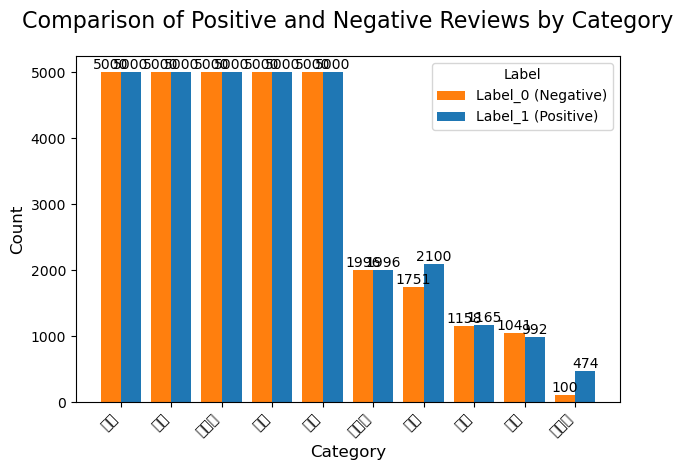

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 设置中文字体
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
plt.rcParams['axes.unicode_minus'] = False  # 显示负号

# 按类别分组，统计0和1的数量
label_counts = pd_all.groupby('cat')['label'].value_counts().unstack().fillna(0)



# 重命名列名
label_counts.columns = ['Label_0 (Negative)', 'Label_1 (Positive)']

# 按总样本量排序（可选）
label_counts['Total'] = label_counts.sum(axis=1)
label_counts = label_counts.sort_values('Total', ascending=False).drop('Total', axis=1)

print("各类别标签分布：")
print(label_counts)

# 设置绘图风格
plt.style.use('default')  # 使用默认风格，避免依赖 seaborn
plt.figure(figsize=(16, 8))  # 增加宽度以防止重叠

# 调整数据格式为长表格（便于绘图）
label_counts_long = label_counts.reset_index().melt(
    id_vars='cat',
    value_vars=['Label_0 (Negative)', 'Label_1 (Positive)'],
    var_name='Label',
    value_name='Count'
)

# 获取类别和标签的唯一值
categories = label_counts_long['cat'].unique()
labels = label_counts_long['Label'].unique()

# 设置颜色
colors = ['#ff7f0e', '#1f77b4']

# 计算条形宽度和位置
num_labels = len(labels)
bar_width = 0.8 / num_labels  # 调整条形宽度以防止重叠
bar_positions = range(len(categories))  # 条形位置

# 创建子图和轴
fig, ax = plt.subplots()

# 绘制每个标签的条形
for i, label in enumerate(labels):
    # 提取当前标签的数据
    data = label_counts_long[label_counts_long['Label'] == label]['Count']
    # 计算条形的偏移
    offset = bar_width * i - bar_width * (num_labels - 1) / 2
    # 绘制条形
    ax.bar([pos + offset for pos in bar_positions], data, bar_width, label=label, color=colors[i])

# 添加图表标签
ax.set_title('Comparison of Positive and Negative Reviews by Category', fontsize=16, pad=20)
ax.set_xlabel('Category', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_xticks(bar_positions)
ax.set_xticklabels(categories, rotation=45, ha='right')  # 旋转x轴标签

# 添加数值标签
for i, bar in enumerate(ax.patches):
    height = bar.get_height()
    ax.annotate(
        f'{int(height)}',
        (bar.get_x() + bar.get_width() / 2, height),
        ha='center',
        va='bottom',
        fontsize=10
    )

# 添加图例
ax.legend(title='Label', loc='upper right')

# 调整布局
plt.tight_layout()

# 显示图表
plt.show()

In [28]:
# # 二分类任务代码示例
# from sklearn.model_selection import train_test_split
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import classification_report

# # 加载数据
# X = pd_all['review']
# y = pd_all['label']

# # 划分训练集和测试集
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # TF-IDF特征提取
# tfidf = TfidfVectorizer(max_features=5000)
# X_train_tfidf = tfidf.fit_transform(X_train)
# X_test_tfidf = tfidf.transform(X_test)

# # 训练模型（逻辑回归）
# model = LogisticRegression()
# model.fit(X_train_tfidf, y_train)

# # 预测与评估
# y_pred = model.predict(X_test_tfidf)
# print(classification_report(y_test, y_pred))

In [29]:
# # 多分类任务代码示例
# from sklearn.preprocessing import LabelEncoder

# # 编码类别标签
# le = LabelEncoder()
# y_cat = le.fit_transform(pd_all['cat'])

# # 划分训练集和测试集
# X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42)

# # TF-IDF特征提取
# X_train_tfidf = tfidf.fit_transform(X_train)
# X_test_tfidf = tfidf.transform(X_test)

# # 训练模型（随机森林）
# model = RandomForestClassifier(n_estimators=100)
# model.fit(X_train_tfidf, y_train)

# # 预测与评估
# y_pred = model.predict(X_test_tfidf)
# print(classification_report(y_test, y_pred, target_names=le.classes_))

In [30]:
# # 分类别二分类代码示例
# from imblearn.over_sampling import SMOTE

# for cat in all_cats:
#     # 提取当前类别的数据
#     subset = pd_all[pd_all['cat'] == cat]
#     X = subset['review']
#     y = subset['label']
    
#     # 划分训练集和测试集
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
#     # TF-IDF特征提取
#     X_train_tfidf = tfidf.fit_transform(X_train)
#     X_test_tfidf = tfidf.transform(X_test)
    
#     # 处理样本不平衡（以热水器为例）
#     if cat == '热水器':
#         smote = SMOTE()
#         X_train_tfidf, y_train = smote.fit_resample(X_train_tfidf, y_train)
    
#     # 训练模型
#     model = LogisticRegression(class_weight='balanced')
#     model.fit(X_train_tfidf, y_train)
    
#     # 评估
#     y_pred = model.predict(X_test_tfidf)
#     print(f"Category: {cat}")
#     print(classification_report(y_test, y_pred))
#     print('-' * 100)

# 2.任务统一处理

### 2.1.加载向量矩阵和数据

In [31]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

# 加载数据
X = np.load("doc_vectors.npy")     # 文档向量矩阵
y_binary = pd_all['label']         # 从原始数据加载二分类情感标签（0/1）

### 2.2.划分训练与测试集

In [32]:
# 划分数据集
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2)

### 2.3.训练模型

In [33]:
# 模型训练
model = LogisticRegression(class_weight='balanced', max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

### 2.4.模型分类

##### 1.二分类情感识别（全局）

In [34]:
# 评估
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))

# 保存模型
# import joblib
# joblib.dump(model, "binary_sentiment_model.pkl")

              precision    recall  f1-score   support

           0       0.89      0.89      0.89      6226
           1       0.89      0.90      0.89      6329

    accuracy                           0.89     12555
   macro avg       0.89      0.89      0.89     12555
weighted avg       0.89      0.89      0.89     12555

AUC: 0.9515486156682077


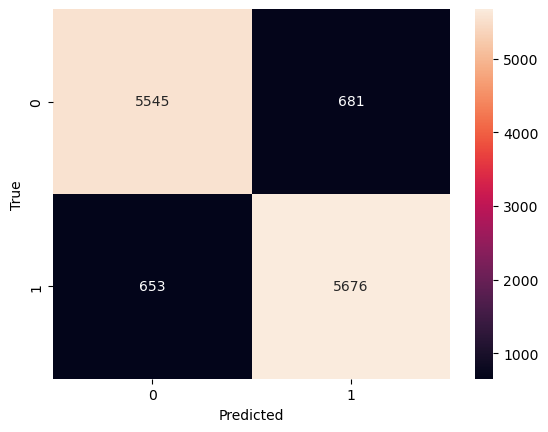

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# 混淆矩阵可视化
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

##### 2.十分类商品类别预测

In [36]:
# from sklearn.preprocessing import LabelEncoder
# from sklearn.model_selection import train_test_split
# from sklearn.svm import SVC
# from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# # 加载数据（示例）
# y_category = pd_all['label']  # 确保pd_all是已定义的DataFrame

# def evaluate_model(model, X_test, y_test):
#     """通用模型评估函数"""
#     y_pred = model.predict(X_test)
#     print("准确率:", accuracy_score(y_test, y_pred))
#     print(classification_report(y_test, y_pred, digits=4))
#     if len(np.unique(y_test)) == 2:  # 二分类专用指标
#         print("AUC:", roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))

# def task_multiclass():
#     """多分类任务完整代码"""
#     # 标签编码
#     le = LabelEncoder()
#     y = le.fit_transform(y_category)
    
#     # 数据划分（假设X是已加载的词向量矩阵）
#     X_train, X_test, y_train, y_test = train_test_split(
#         X, y,
#         test_size=0.2,
#         stratify=y,  # 保持类别分布
#         random_state=42
#     )
    
#     # 初始化模型（优化参数版）
#     model = SVC(
#         class_weight='balanced',
#         kernel='rbf',
#         probability=True,
#         gamma='scale',       # 自动调整gamma参数
#         C=1.0,              # 正则化强度
#         decision_function_shape='ovr',
#         random_state=42
#     )
    
#     # 训练模型
#     model.fit(X_train, y_train)
    
#     # 评估模型
#     print("\n十分类性能：")
#     evaluate_model(model, X_test, y_test)
    
#     # 打印类别映射（修正括号问题）
#     print("类别对应关系：", dict(zip(le.classes_, range(len(le.classes_)))))
#     # 或者更直观的显示方式：
#     print("\n类别编码映射表：")
#     for i, class_name in enumerate(le.classes_):
#         print(f"{class_name} => {i}")

# # 执行任务
# task_multiclass()

In [37]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# 加载预生成数据 
# 加载文档向量矩阵
X = np.load("doc_vectors.npy")

y_binary = pd_all['label']     # 二分类标签（0/1）
y_category = pd_all['cat']      # 多分类标签（类别名称或编码）

# 加载数据后立即添加以下代码
print("X 样本数:", X.shape[0])
print("y_category 样本数:", len(y_category))

X 样本数: 62773
y_category 样本数: 62773


In [38]:


#通用评估函数
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print("准确率:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred, digits=4))
    if len(np.unique(y_test)) == 2:  # 二分类额外指标
        print("AUC:", roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))

# 任务2：十分类   
def task_multiclass():
    # 标签编码
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    y = le.fit_transform(y_category)
    
    # 数据划分
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.2,
        stratify=y,
        random_state=42
    )
    
    # 训练模型
    model = SVC(
        class_weight='balanced',
        probability=True,
        kernel='rbf',
        decision_function_shape='ovr'
    )
    model.fit(X_train, y_train)
    
    # 评估
    print("\n十分类性能：")
    evaluate_model(model, X_test, y_test)
    print("类别对应关系：", dict(zip(le.classes_, range(len(le.classes_)))))

task_multiclass()


十分类性能：
准确率: 0.8637992831541219
              precision    recall  f1-score   support

           0     0.9002    0.9494    0.9241       770
           1     0.8027    0.7325    0.7660      2000
           2     0.7684    0.8989    0.8285       465
           3     0.9276    0.8455    0.8846      2000
           4     0.7800    0.8350    0.8066      2000
           5     0.3217    0.7217    0.4450       115
           6     0.9854    0.9926    0.9890       407
           7     0.8764    0.8615    0.8689      2000
           8     0.8916    0.9173    0.9043       798
           9     0.9862    0.9640    0.9750      2000

    accuracy                         0.8638     12555
   macro avg     0.8240    0.8718    0.8392     12555
weighted avg     0.8718    0.8638    0.8661     12555

类别对应关系： {'书籍': 0, '平板': 1, '手机': 2, '水果': 3, '洗发水': 4, '热水器': 5, '蒙牛': 6, '衣服': 7, '计算机': 8, '酒店': 9}


##### 3. 分品类情感识别（10个二分类模型）

In [ ]:
# def task_per_category():
#     # 获取类别列表
#     categories = y_category.unique()
    
#     for cat in categories:
#         # 筛选当前类别数据
#         mask = (y_category == cat)
#         X_cat = X[mask]
#         y_cat = y_binary[mask]
        
#         # 跳过样本过少的类别
#         if len(X_cat) < 100:
#             print(f"\n跳过类别 {cat}（样本数不足）")
#             continue
            
#         # 数据划分
#         X_train, X_test, y_train, y_test = train_test_split(
#             X_cat, y_cat,
#             test_size=0.2,
#             stratify=y_cat,
#             random_state=42
#         )
        
#         # 训练模型
#         model = LogisticRegression(
#             class_weight='balanced',
#             solver='liblinear',
#             max_iter=500
#         )
#         model.fit(X_train, y_train)
        
#         # 评估
#         print(f"\n类别 [{cat}] 二分类性能：")
#         evaluate_model(model, X_test, y_test)
# task_per_category()
def task_per_category():
    # 获取类别列表
    categories = y_category.unique()
    
    print("\n将处理的类别：")
    print(categories)
    
    for cat in categories:
        print(f"\n处理类别：{cat}")
        
        # 筛选当前类别数据
        mask = (y_category == cat)
        X_cat = X[mask]
        y_cat = y_binary[mask]
        
        # 跳过样本过少的类别
        if len(X_cat) < 100:
            print(f"\n跳过类别 {cat}（样本数不足）")
            continue
            
        # 数据划分
        X_train, X_test, y_train, y_test = train_test_split(
            X_cat, y_cat,
            test_size=0.2,
            stratify=y_cat,
            random_state=42
        )
        
        # 训练模型
        model = LogisticRegression(
            class_weight='balanced',
            solver='liblinear',
            max_iter=500
        )
        model.fit(X_train, y_train)
        
        # 评估
        print(f"\n类别 [{cat}] 二分类性能：")
        evaluate_model(model, X_test, y_test)

# 指定要打印的类别
specified_categories = ['书籍', '平板', '手机', '水果', '洗发水', '热水器', '蒙牛', '衣服', '计算机', '酒店']


# 调用函数
task_per_category()


将处理的类别：
['书籍' '平板' '手机' '水果' '洗发水' '热水器' '蒙牛' '衣服' '计算机' '酒店']

处理类别：书籍

类别 [书籍] 二分类性能：
准确率: 0.8521400778210116
              precision    recall  f1-score   support

           0     0.8435    0.8291    0.8362       351
           1     0.8592    0.8714    0.8652       420

    accuracy                         0.8521       771
   macro avg     0.8513    0.8502    0.8507       771
weighted avg     0.8520    0.8521    0.8520       771

AUC: 0.9134513634513634

处理类别：平板

类别 [平板] 二分类性能：
准确率: 0.9195
              precision    recall  f1-score   support

           0     0.9225    0.9160    0.9192      1000
           1     0.9166    0.9230    0.9198      1000

    accuracy                         0.9195      2000
   macro avg     0.9195    0.9195    0.9195      2000
weighted avg     0.9195    0.9195    0.9195      2000

AUC: 0.9681894999999999

处理类别：手机

类别 [手机] 二分类性能：
准确率: 0.9182795698924732
              precision    recall  f1-score   support

           0     0.9110    0.9267    0.9188 